In [1]:
!mkdir results

mkdir: cannot create directory ‘results’: File exists


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns
import matplotlib.pyplot as plt
import numpy

In [3]:
from torch.utils.data import Subset
import numpy as np

transform = transforms.Compose(                                 # 이미지 변환을 위한 파이프라인
    [transforms.ToTensor(),                                     # PyToch 텐서로 변환 -> 이미지를 0~1사이 값으로 만듦
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])   # 이미지를 정규화함 -> 평균, 표준편차 (0.5, 0.5, 0.5) -> 각 채널의 값이 -1에서 1 사이로 정규화

# CIFAR100 train dataset 가져오기
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)

# 클래스별로 인덱스를 저장할 딕셔너리 생성
class_indices = {class_idx: [] for class_idx in range(len(trainset.classes))}

# 각 데이터의 클래스 인덱스를 확인하고 해당하는 클래스 인덱스에 해당하는 리스트에 인덱스 저장
for idx, (_, label) in enumerate(trainset):
    class_indices[label].append(idx)

# 클래스별로 train set과 validation set의 크기 결정
train_size_per_class = int(0.8 * len(trainset) / len(trainset.classes))
valid_size_per_class = len(trainset) // len(trainset.classes) - train_size_per_class

# train set과 validation set을 담을 리스트 초기화
train_indices = []
valid_indices = []

# 클래스별로 데이터를 train set과 validation set으로 분할
for class_idx, indices in class_indices.items():
    # 클래스별로 인덱스를 랜덤하게 섞음
    np.random.shuffle(indices)
    # train set에 해당하는 인덱스와 validation set에 해당하는 인덱스를 각각 추가
    train_indices.extend(indices[:train_size_per_class])
    valid_indices.extend(indices[train_size_per_class:train_size_per_class+valid_size_per_class])

# train set과 validation set을 Subset으로 생성
train_subset = Subset(trainset, train_indices)
valid_subset = Subset(trainset, valid_indices)

# partition에 추가
partition = {'train': train_subset, 'val': valid_subset}

# 갯수 확인
train_dataset_size = len(train_subset)
valid_dataset_size = len(valid_subset)
print(train_dataset_size, valid_dataset_size)

Files already downloaded and verified
40000 10000


32 32


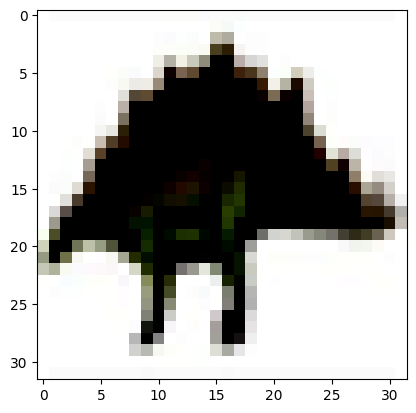

In [4]:
# dataset가 잘 load 되었는지 체크
sample = trainset[1][0].numpy()
sample = numpy.transpose(sample, (1,2,0))
height, width, _ = sample.shape
plt.imshow(sample)
print(height, width)

In [5]:
# backborn model 지정
# VGGnet기반 숫자는 filter size, M은 Max pooling
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [6]:
# CNN Architecture 지정

class CNN(nn.Module):

    def __init__(self, model_code, in_channels, out_dim, act, use_bn):
        super(CNN, self).__init__()

        # activation function 설정
        if act == 'relu':
            self.act = nn.ReLU()
        elif act == 'sigmoid':
            self.act = nn.Sigmoid()
        elif act == 'tanh':
            self.act = nn.TanH()
        else:
            raise ValueError("Not a valid activation function code")

        # CNN 레이어들을 생성하는 함수 호출하여 레이어 생성
        self.layers = self._make_layers(model_code, in_channels, use_bn)
        self.dropout1 = nn.Dropout(0.3)
        self.classifer = nn.Sequential(nn.Linear(512, 256),
                                       self.act,
                                       self.dropout1,
                                       nn.Linear(256, out_dim))
    # forward 연산 정의
    def forward(self, x):
        x = self.layers(x)        # CNN 레이어들을 통과
        x = x.view(x.size(0), -1) # Flatten 연산, 배치 크기는 유지하고 나머지 차원을 펼침
        x = self.classifer(x)     # Classifier 통과
        return x

    # CNN 레이어들을 생성하는 함수
    def _make_layers(self, model_code, in_channels, use_bn):
        layers = []
        for x in cfg[model_code]:
            if x == 'M':
                # MaxPooling 레이어 생성
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                # Convolution layer 구성
                layers += [nn.Conv2d(in_channels=in_channels,
                                     out_channels=x,  # out_channels은 forward 연산 이후 x
                                     kernel_size=3,   # CNN kernel_size
                                     stride=1,        # CNN kernel의 stride
                                     padding=1)]      # CNN kernel의 padding

                # BN(Batch Normalization을 사용하는 경우 아래를 사용)
                if use_bn:
                    layers += [nn.BatchNorm2d(x)]
                layers += [self.act]   # 레이어 이후 활성화 함수 적용
                in_channels = x        # 다음 들어가야하는 레이어에 입력 채널 수 업데이트

        return nn.Sequential(*layers)  # 생성된 레이어들을 순차적으로 적용하여 모델을 정의(layer 리스트 내의 모든 레이어를 순차적으로 적용하여 하나의 시퀀스로 묶음)

In [7]:
# train session
def train(net, partition, optimizer, criterion, args):
    # trainset을 가져와서 batch_size, shuffle, num_workers(병렬적으로 데이터를 로드)
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                              batch_size=args.train_batch_size,
                                              shuffle=True, num_workers=2)
    net.train() # 학습모드 설정

    correct = 0 # 맞은 예측 수
    total = 0 # 전체 데이터 수
    train_loss = 0.0 # train_loss
    for i, data in enumerate(trainloader, 0): # 각 배치에 대해 반복
        optimizer.zero_grad() # 옵티마이저 그래디언트 초기화 -> 다음 step으로 가기 위함

        # input(입력 데이터, 레이블)
        inputs, labels = data
        inputs = inputs.cuda() # GPU 연산을 위해 GPU전송
        labels = labels.cuda() # GPU 연산을 위해 GPU전송
        outputs = net(inputs)  # network를 통과한 output값 (예측값)

        loss = criterion(outputs, labels) # loss 계산
        loss.backward() # backpropagaion
        optimizer.step() # optimizer step

        train_loss += loss.item() # loss를 추가
        _, predicted = torch.max(outputs.data, 1) # output에서 가장 높은 확률값의 class 선택
        total += labels.size(0) # 데이터 수 업데이트
        correct += (predicted == labels).sum().item() # predict update(correct)

    train_loss = train_loss / len(trainloader)  # 평균 loss
    train_acc = 100 * correct / total # accuracy
    return net, train_loss, train_acc

In [8]:
# validation seccison
def validate(net, partition, criterion, args):
    # validation set을 가져와서 batch_size, shuffle, num_workers(병렬적으로 데이터를 로드)
    valloader = torch.utils.data.DataLoader(partition['val'],
                                            batch_size=args.test_batch_size,
                                            shuffle=False, num_workers=2)

    net.eval()  # 네트워크를 평가 모드 -> backprop을 안하기를 위한 목적도 있지만 Dropout이 적용될 경우 적용하지 않기 위함도 존재

    correct = 0 # 맞은 예측 수
    total = 0 # 전체 데이터 수
    val_loss = 0 # validation_loss
    with torch.no_grad(): # graident X
        for data in valloader:  # 배치마다 data 반복
            images, labels = data
            images = images.cuda()  # GPU 연산을 위해 GPU전송
            labels = labels.cuda()  # GPU 연산을 위해 GPU전송
            outputs = net(images)   # network를 통과한 output값 (예측값)

            loss = criterion(outputs, labels) # loss 계산

            val_loss += loss.item() # loss를 추가
            _, predicted = torch.max(outputs.data, 1) # output에서 가장 높은 확률값의 class 선택
            total += labels.size(0) # 데이터 수 업데이트
            correct += (predicted == labels).sum().item() # predict update(correct)

        val_loss = val_loss / len(valloader)  # 평균 loss
        val_acc = 100 * correct / total # accuracy
    return val_loss, val_acc

In [9]:
def experiment(partition, args):

    # CNN model 지정
    net = CNN(model_code = args.model_code,
              in_channels = args.in_channels,
              out_dim = args.out_dim,
              act = args.act,
              use_bn = args.use_bn
              )
    # GPU 연산을 위해 cuda로
    net.cuda()

    criterion = nn.CrossEntropyLoss() # loss 계산(class 분류)을 위한 Loss계산법 정의
    if args.optim == 'SGD': # SGD를 사용할 때
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop': # RMSProp를 사용할 때
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':  # Adam를 사용할 때
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice') # 위의 optim을 사용하지 않았을때 Error송출

    # 각 loss, acc에 대해 저장할 리스트 생성
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []


    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()  # 학습시간을 계산하기 위해 초기 시간 기록
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args) # 위에서 정의 한 train function 호출
        val_loss, val_acc = validate(net, partition, criterion, args) # 위에서 정의한 validation
        te = time.time() # 종료 시간 -> 한번 학습이 돌아갔을때의 시간 (te - ts -> 학습시간)

        # 각 loss를 저장함
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # 한 epoch당 acc, loss를 뱉어줌
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))

        # 매 에폭이 끝날 때마다 모델의 가중치를 저장
        if (epoch + 1) % 10 == 0:
            weight_save_path = f"saved_weights_epoch_{epoch + 1}.pth"  # 에폭에 따른 파일명 생성
            torch.save(net.state_dict(), weight_save_path)

    # test를 할 떄 불러옴
    #test_acc = test(net, partition, args)

    # 결과를 result에 따로 저장함
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    #result['test_acc'] = test_acc
    return vars(args), result

In [10]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']  # exp_name을 가져옴
    del setting['epoch']  # epoch key delete
    del setting['test_batch_size']  # test_batch delete

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]  # 설정을 해싱
    filename = './results/{}-{}.json'.format(exp_name, hash_key)  # 결과를 저장할 파일 경로 지정
    result.update(setting)  # 설정을 result에 update
    with open(filename, 'w') as f:  # exp_name, hash_key를 가지는 파일 이름으로 저장
        json.dump(result, f)

In [11]:
# ====== Random Seed Initialization ====== #
# 동일한 코드를 여러번 실행할 때 동일한 결과를 얻을 수 있는데 이를 방지하기 위함
seed = 123
np.random.seed(seed)  # numpy random seed
torch.manual_seed(seed) # torch random seed

parser = argparse.ArgumentParser()  # 명령행 옵션을 파싱
args = parser.parse_args("")  # 파싱 이후 결과 저장
args.exp_name = "exp1_lr_model_code"  # exp_name 저장

# ====== Model ====== #
args.model_code = 'VGG11'
args.in_channels = 3  # input channel
args.out_dim = 100   # output channel
args.act = 'relu'   # activation function

# ====== Regularization ======= #
args.l2 = 0.01   # L2 Norm
args.use_bn = True  # Batch Normalization

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.00005  # learning rate
args.epoch = 100   # epoch

args.train_batch_size = 512 # train_batch_size
args.test_batch_size = 1024 # test_batch_size

setting, result = experiment(partition, args)
save_exp_result(setting, result)


Epoch 0, Acc(train/val): 7.30/13.97, Loss(train/val) 4.29/3.95. Took 14.92 sec
Epoch 1, Acc(train/val): 16.64/23.47, Loss(train/val) 3.72/3.46. Took 14.13 sec
Epoch 2, Acc(train/val): 24.07/28.56, Loss(train/val) 3.28/3.12. Took 14.26 sec
Epoch 3, Acc(train/val): 31.36/32.01, Loss(train/val) 2.90/2.87. Took 14.91 sec
Epoch 4, Acc(train/val): 38.99/34.20, Loss(train/val) 2.54/2.77. Took 18.23 sec
Epoch 5, Acc(train/val): 47.12/36.09, Loss(train/val) 2.19/2.65. Took 16.76 sec
Epoch 6, Acc(train/val): 56.84/36.94, Loss(train/val) 1.82/2.59. Took 14.37 sec
Epoch 7, Acc(train/val): 67.19/36.90, Loss(train/val) 1.45/2.58. Took 14.50 sec
Epoch 8, Acc(train/val): 77.77/36.92, Loss(train/val) 1.08/2.61. Took 14.80 sec
Epoch 9, Acc(train/val): 86.91/37.25, Loss(train/val) 0.75/2.58. Took 14.12 sec
Epoch 10, Acc(train/val): 93.33/36.56, Loss(train/val) 0.49/2.67. Took 14.75 sec
Epoch 11, Acc(train/val): 96.93/37.05, Loss(train/val) 0.32/2.65. Took 14.57 sec
Epoch 12, Acc(train/val): 98.64/36.64, 

KeyboardInterrupt: 